#### Imports

In [214]:
from collections import defaultdict
import itertools
import os
from tabulate import tabulate
from pprint import pprint

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline

In [216]:
import networkx as nx
import pandas as pd
pd.options.display.max_columns = 100

In [217]:
# import plotly.plotly as py
# import plotly.graph_objs as go

## Learning Object-Centered Models (LOCM) 
This code combines LOCM1 and LOCM2 algorithms and is last part of the pipeline that I use in my thesis to generate PDDL models from instructional texts.

- Step 1: Find classes and make transition graphs.
- Step 2: Get transistion sets from LOCM2 algorithm
- Step 3: Create FSMs
- Step 4: Perform Zero Analysis and add new FSM if necessary.
- Step 5: Create and test hypothesis for state parameters
- Step 6: Create and merge state parameters
- Step 7: Remove parameter flaws
- Step 8: Extract static preconditions
- Step 9: Form action schemas

In [218]:
input_file_name = "locm_data/rocket_locmfeb.txt" #name of the file containing action sequences
input_file_name = "locm_data/tea.txt"
input_file_name = "locm_data/childsnack1.txt"
input_file_name = "locm_data/fire_alarm1"
input_file_name = "locm_data/driverlog1.txt"
domain_name = input_file_name.split('/')[-1].split('.')[0] #domain name is the name of the file

In [219]:
print(domain_name)

driverlog1


### Read input file

In [220]:
def read_file(file_path):
    '''
    Read the input data and return list of action sequences.
    Each sequence is a list of action-argumentlist tuples.
    '''
    file = open(input_file_name, 'r')
    sequences = []
    for line in file:
        
        actions = []
        arguments = []
        if line and not line.isspace() and len(line)>1:
            sequence = line.rstrip("\n\r").lstrip("\n\r").lower() 
            action_defs = sequence.split("),")

            for action_def in action_defs:
                action = action_def.split('(')[0].strip(")\n\r").strip()
                argument = action_def.split('(')[1].strip(")\n\r")
                actions.append(action.strip())
                argument_list = argument.split(',')
                argument_list = [x.strip() for x in argument_list]
                arguments.append(argument_list)
            
            actarg_tuples = zip(actions,arguments)
            sequences.append(list(actarg_tuples))
    return sequences

def print_sequences(sequences):
    for seq in sequences:
        for action in seq:
            print(action)
        print()

In [221]:
sequences = read_file(input_file_name)

In [222]:
print_sequences(sequences) #print first sequence actions.

('walk', ['driver1', 's2', 'p1-2'])
('walk', ['driver1', 'p1-2', 's1'])
('walk', ['driver1', 's1', 'p1-0'])
('walk', ['driver1', 'p1-0', 's0'])
('board-truck', ['driver1', 'truck1', 's0'])
('drive-truck', ['truck1', 's0', 's1', 'driver1'])
('disembark-truck', ['driver1', 'truck1', 's1'])

('board-truck', ['driver1', 'truck3', 's3'])
('unload-truck', ['package5', 'truck3', 's3'])
('disembark-truck', ['driver1', 'truck3', 's3'])

('unload-truck', ['package5', 'truck3', 's3'])
('board-truck', ['driver1', 'truck3', 's3'])
('load-truck', ['package5', 'truck3', 's3'])

('load-truck', ['package5', 'truck3', 's3'])
('disembark-truck', ['driver1', 'truck3', 's3'])

('board-truck', ['driver1', 'truck3', 's3'])
('disembark-truck', ['driver1', 'truck3', 's3'])
('load-truck', ['package5', 'truck3', 's3'])
('board-truck', ['driver1', 'truck3', 's3'])

('walk', ['driver1', 's2', 'p1-2'])
('walk', ['driver1', 'p1-2', 's1'])
('walk', ['driver1', 's1', 'p1-0'])
('walk', ['driver1', 'p1-0', 's0'])
('boar

In [223]:
print(len(sequences)) #print number of plans

8


### Step 1.1: Find classes 

User can fix this easily 
#### Improvement 1 : User names the classes through user input 

In [224]:
transitions = set() # A transition is denoted by action_name + argument_number.
arguments = set()
actions = set()

In [225]:
for seq in sequences:
    for actarg_tuple in seq:
        actions.add(actarg_tuple[0])
        for j, arg in enumerate(actarg_tuple[1]):
            transitions.add(actarg_tuple[0]+"."+str(j))
            arguments.add(arg)

print("\nActions")
print(actions)
print("\nTransitions")
print(transitions)
print("\nArguments/Objects")
print(arguments)


Actions
{'unload-truck', 'disembark-truck', 'load-truck', 'walk', 'drive-truck', 'board-truck'}

Transitions
{'disembark-truck.2', 'load-truck.1', 'load-truck.2', 'disembark-truck.1', 'disembark-truck.0', 'load-truck.0', 'drive-truck.2', 'board-truck.1', 'board-truck.0', 'walk.0', 'board-truck.2', 'drive-truck.0', 'unload-truck.1', 'drive-truck.1', 'walk.1', 'drive-truck.3', 'walk.2', 'unload-truck.2', 'unload-truck.0'}

Arguments/Objects
{'truck2', 'p3-2', 'p3-4', 'p0-1', 'package3', 'p1-2', 'package4', 'package1', 's3', 's4', 's2', 's0', 'driver2', 's5', 'p1-0', 'package2', 'package5', 'truck3', 'driver1', 'truck1', 's1'}


In [226]:
def get_actarg_dictionary(sequences):
    d = defaultdict(list)
    for seq in sequences:
        for actarg_tuple in seq:
            d[actarg_tuple[0]].append(actarg_tuple[1])
    return d

In [227]:
d = get_actarg_dictionary(sequences)
for k,v in d.items():
        print("{} - {}".format(k,v))

walk - [['driver1', 's2', 'p1-2'], ['driver1', 'p1-2', 's1'], ['driver1', 's1', 'p1-0'], ['driver1', 'p1-0', 's0'], ['driver1', 's2', 'p1-2'], ['driver1', 'p1-2', 's1'], ['driver1', 's1', 'p1-0'], ['driver1', 'p1-0', 's0'], ['driver1', 's4', 'p3-4'], ['driver1', 'p3-4', 's3'], ['driver2', 's1', 'p0-1'], ['driver2', 'p0-1', 's0'], ['driver2', 's3', 'p3-2'], ['driver2', 'p3-2', 's2'], ['driver2', 's3', 'p3-4'], ['driver2', 'p3-4', 's4']]
board-truck - [['driver1', 'truck1', 's0'], ['driver1', 'truck3', 's3'], ['driver1', 'truck3', 's3'], ['driver1', 'truck3', 's3'], ['driver1', 'truck3', 's3'], ['driver1', 'truck1', 's0'], ['driver1', 'truck2', 's4'], ['driver2', 'truck1', 's0'], ['driver1', 'truck2', 's1'], ['driver1', 'truck2', 's1'], ['driver1', 'truck2', 's1'], ['driver2', 'truck2', 's0'], ['driver2', 'truck1', 's2'], ['driver2', 'truck1', 's4'], ['driver2', 'truck1', 's4']]
drive-truck - [['truck1', 's0', 's1', 'driver1'], ['truck1', 's0', 's1', 'driver1'], ['truck2', 's4', 's1', 'd

#### Get classes util functions

In [228]:
def get_classes(d):
    # TODO incorporate word similarity in get classes.
    c = defaultdict(set)
    for k,v in d.items():
        for arg_list in v:
            for i,object in enumerate(arg_list):
                c[k,i].add(object)

    sets = c.values()
    classes = []
    # remove duplicate classes
    for s in sets:
        if s not in classes:
            classes.append(s)

    # now do pairwise intersections of all values. If intersection, combine them; then return the final sets.
    classes_copy = list(classes)
    while True:
        combinations = list(itertools.combinations(classes_copy,2))
        intersections_count = 0
        for combination in combinations:
            if combination[0].intersection(combination[1]):
                intersections_count +=1

                if combination[0] in classes_copy:
                    classes_copy.remove(combination[0])
                if combination[1] in classes_copy:
                    classes_copy.remove(combination[1])
                classes_copy.append(combination[0].union(combination[1]))

        if intersections_count==0:
            # print("no intersections left")
            break

    return classes_copy

# TODO: Can use better approach here. NER will help.
def get_class_names(classes):
    # Name the class to first object found ignoring the digits in it
    class_names = []
    for c in classes:
        for object in c:
            object = ''.join([i for i in object if not i.isdigit()])
            class_names.append(object)
            break
    return class_names

def get_class_index(arg,classes):
    for class_index, c in enumerate(classes):
        if arg in c:
            return class_index #it is like breaking out of the loop
    print("Error:class index not found") #this statement is only executed if class index is not returned.

In [229]:
classes = get_classes(d) #sorts of object
print("\nSorts/Classes")
print(classes)

class_names = get_class_names(classes)
print("\nExtracted class names")
print(class_names)


Sorts/Classes
[{'driver2', 'driver1'}, {'package4', 'package1', 'package2', 'package3', 'package5'}, {'truck3', 'truck2', 'truck1'}, {'s3', 's5', 'p1-0', 's4', 's2', 'p3-2', 's0', 'p3-4', 'p0-1', 's1', 'p1-2'}]

Extracted class names
['driver', 'package', 'truck', 's']


In [230]:
############ (Optional) User Input ############
# Give user an option to change class names.
# class_names[0] = 'rocket'
# class_names[1] = 'cargo'
class_names[3] = 'location'
print(class_names)


['driver', 'package', 'truck', 'location']


#### Assumptions
- Each object of a same class undergoes similar kind of transition.
- Objects of same class in a same action undergo similar kind of transition.

In [231]:
# change transitions to be more meaningful by incorporating class_names.
full_transitions = set()
for seq in sequences:
    for actarg_tuple in seq:
        actions.add(actarg_tuple[0])
        for j, arg in enumerate(actarg_tuple[1]):
            full_transitions.add(actarg_tuple[0]+"."+class_names[get_class_index(arg,classes)]+"."+str(j))
            arguments.add(arg)

print("\nActions")
print(actions)
print("\nTransitions")
print(transitions)
print(full_transitions)
print("\nArguments/Objects")
print(arguments)


Actions
{'unload-truck', 'disembark-truck', 'load-truck', 'walk', 'drive-truck', 'board-truck'}

Transitions
{'disembark-truck.2', 'load-truck.1', 'load-truck.2', 'disembark-truck.1', 'disembark-truck.0', 'load-truck.0', 'drive-truck.2', 'board-truck.1', 'board-truck.0', 'walk.0', 'board-truck.2', 'drive-truck.0', 'unload-truck.1', 'drive-truck.1', 'walk.1', 'drive-truck.3', 'walk.2', 'unload-truck.2', 'unload-truck.0'}
{'walk.location.2', 'drive-truck.location.2', 'walk.driver.0', 'disembark-truck.driver.0', 'disembark-truck.location.2', 'board-truck.driver.0', 'unload-truck.truck.1', 'drive-truck.truck.0', 'unload-truck.location.2', 'drive-truck.location.1', 'unload-truck.package.0', 'load-truck.package.0', 'board-truck.truck.1', 'load-truck.truck.1', 'walk.location.1', 'board-truck.location.2', 'drive-truck.driver.3', 'load-truck.location.2', 'disembark-truck.truck.1'}

Arguments/Objects
{'truck2', 'p3-2', 'p3-4', 'p0-1', 'package3', 'p1-2', 'package4', 'package1', 's3', 's4', 's2'

In [232]:
print("\nNumber of Actions: {},\nNumber of unique transitions: {},\nNumber of unique objects (arguments): {},\nNumber of classes/sorts: {}".format(len(actions), len(transitions), len(arguments), len(classes)))


Number of Actions: 6,
Number of unique transitions: 19,
Number of unique objects (arguments): 21,
Number of classes/sorts: 4


### Step 1.2: Make transition graphs

User can fix these easily as well. (Cytoscape).

Building Transition graph util

In [233]:
def build_and_save_transition_graphs(classes, domain_name, class_names):
    # There should be a graph for each class of objects.
    graphs = []  # number of graphs = number of sorts.
    # Initialize all graphs empty
    for sort in classes:
        graphs.append(nx.DiGraph())

    consecutive_transition_lists = [] #list of consecutive transitions per object instance per sequence.

    for m, arg in enumerate(arguments):  # for all arguments (objects found in sequences)
        for n, seq in enumerate(sequences):  # for all sequences
            consecutive_transition_list = list()  # consecutive transition list for a sequence and an object (arg)
            for i, actarg_tuple in enumerate(seq):
                for j, arg_prime in enumerate(actarg_tuple[1]):  # for all arguments in actarg tuples
                    if arg == arg_prime:  # if argument matches arg
                        node = actarg_tuple[0] + "." +  str(j)
#                         node = actarg_tuple[0] +  "." + class_names[get_class_index(arg,classes)] + "." +  str(j)  # name the node of graph which represents a transition
                        consecutive_transition_list.append(node)  # add node to the cons_transition for sequence and argument

                        # for each class append the nodes to the graph of that class
                        class_index = get_class_index(arg_prime, classes)  # get index of class to which the object belongs to
                        graphs[class_index].add_node(node)  # add node to the graph of that class

            consecutive_transition_lists.append([n, arg, consecutive_transition_list])

    # print(consecutive_transition_lists)
    # for all consecutive transitions add edges to the appropriate graphs.
    for cons_trans_list in consecutive_transition_lists:
        # print(cons_trans_list)
        seq_no = cons_trans_list[0]  # get sequence number
        arg = cons_trans_list[1]  # get argument
        class_index = get_class_index(arg, classes)  # get index of class
        # add directed edges to graph of that class
        for i in range(0, len(cons_trans_list[2]) - 1):
                if graphs[class_index].has_edge(cons_trans_list[2][i], cons_trans_list[2][i + 1]):
                    graphs[class_index][cons_trans_list[2][i]][cons_trans_list[2][i + 1]]['weight'] += 1
                else:
                    graphs[class_index].add_edge(cons_trans_list[2][i], cons_trans_list[2][i + 1], weight=1)


    
    # make directory if doesn't exist
    dirName = "output/"+ domain_name
    if not os.path.exists(dirName):
        os.makedirs(dirName)
        print("Directory ", dirName, " Created ")
    else:
        print("Directory ", dirName, " already exists")
    empty_directory(dirName)


    # plot and save all the graphs
    adjacency_matrix_list = plot_and_save(graphs) # list of adjacency matrices per class

    return adjacency_matrix_list

def plot_and_save(graphs):
    adjacency_matrix_list = [] # list of adjacency matrices per class
    
    for index, G in enumerate(graphs):
        # TODO: Can use cytoscape or gephi for changes in Transition graphs (due to errors in data extracted).
        nx.write_graphml(G, "output/"+ domain_name + "/" +  class_names[index] + ".graphml")

        nx.draw(G, arrow_style='fancy', with_labels=True)
        labels = nx.get_edge_attributes(G, 'weight')
        pos = nx.spring_layout(G)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.show()
        print("Nodes:{}".format(G.nodes()))
        print("Edges:{}".format(G.edges()))

        # TODO: save dataframes in cache and reload them.
        # A = nx.to_numpy_matrix(G, nodelist=G.nodes())
        
        df = nx.to_pandas_adjacency(G, nodelist=G.nodes(), dtype=int)
        adjacency_matrix_list.append(df)
    return adjacency_matrix_list

##### Utils

In [234]:
def empty_directory(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            # elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

def findsubsets(S,m):
    return set(itertools.combinations(S, m))

def print_table(matrix):
    print(tabulate(matrix, headers='keys', tablefmt='psql'))

##### Transition Graphs

Directory  output/driverlog1  already exists


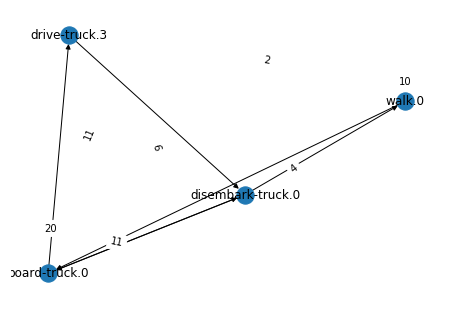

Nodes:['board-truck.0', 'drive-truck.3', 'disembark-truck.0', 'walk.0']
Edges:[('board-truck.0', 'drive-truck.3'), ('board-truck.0', 'disembark-truck.0'), ('drive-truck.3', 'drive-truck.3'), ('drive-truck.3', 'disembark-truck.0'), ('disembark-truck.0', 'walk.0'), ('disembark-truck.0', 'board-truck.0'), ('walk.0', 'walk.0'), ('walk.0', 'board-truck.0')]


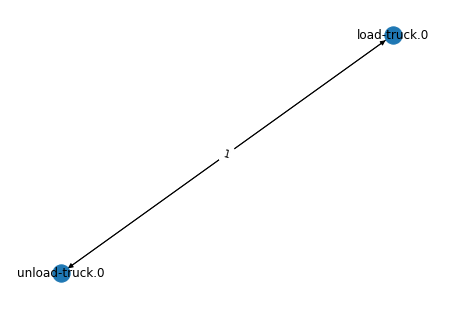

Nodes:['load-truck.0', 'unload-truck.0']
Edges:[('load-truck.0', 'unload-truck.0'), ('unload-truck.0', 'load-truck.0')]


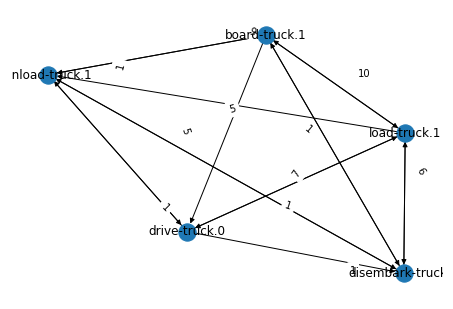

Nodes:['board-truck.1', 'load-truck.1', 'drive-truck.0', 'unload-truck.1', 'disembark-truck.1']
Edges:[('board-truck.1', 'load-truck.1'), ('board-truck.1', 'drive-truck.0'), ('board-truck.1', 'unload-truck.1'), ('board-truck.1', 'disembark-truck.1'), ('load-truck.1', 'drive-truck.0'), ('load-truck.1', 'disembark-truck.1'), ('load-truck.1', 'board-truck.1'), ('load-truck.1', 'unload-truck.1'), ('drive-truck.0', 'drive-truck.0'), ('drive-truck.0', 'unload-truck.1'), ('drive-truck.0', 'disembark-truck.1'), ('drive-truck.0', 'load-truck.1'), ('unload-truck.1', 'drive-truck.0'), ('unload-truck.1', 'disembark-truck.1'), ('unload-truck.1', 'board-truck.1'), ('disembark-truck.1', 'board-truck.1'), ('disembark-truck.1', 'load-truck.1'), ('disembark-truck.1', 'unload-truck.1')]


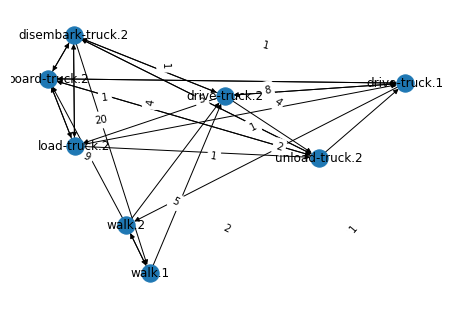

Nodes:['walk.2', 'walk.1', 'board-truck.2', 'unload-truck.2', 'disembark-truck.2', 'load-truck.2', 'drive-truck.2', 'drive-truck.1']
Edges:[('walk.2', 'walk.1'), ('walk.2', 'drive-truck.2'), ('walk.2', 'board-truck.2'), ('walk.1', 'walk.2'), ('walk.1', 'drive-truck.2'), ('board-truck.2', 'unload-truck.2'), ('board-truck.2', 'load-truck.2'), ('board-truck.2', 'disembark-truck.2'), ('board-truck.2', 'drive-truck.1'), ('unload-truck.2', 'disembark-truck.2'), ('unload-truck.2', 'board-truck.2'), ('unload-truck.2', 'drive-truck.1'), ('disembark-truck.2', 'load-truck.2'), ('disembark-truck.2', 'walk.1'), ('disembark-truck.2', 'board-truck.2'), ('disembark-truck.2', 'unload-truck.2'), ('disembark-truck.2', 'drive-truck.2'), ('load-truck.2', 'disembark-truck.2'), ('load-truck.2', 'board-truck.2'), ('load-truck.2', 'drive-truck.1'), ('load-truck.2', 'unload-truck.2'), ('drive-truck.2', 'unload-truck.2'), ('drive-truck.2', 'drive-truck.1'), ('drive-truck.2', 'load-truck.2'), ('drive-truck.2', 'd

In [235]:
#### Build weighted directed graphs for transitions.
adjacency_matrix_list = build_and_save_transition_graphs(classes, domain_name, class_names)

### Step 2: Get Transition Sets from LOCM2

Algorithm: LOCM2
Input : 
- T_all = set of observed transitions for a sort/class
- H : Set of holes - each hole is a set of two transitions.
- P : Set of pairs <t1,t2> i.e. consecutive transitions.
- E : Set of example sequences of actions.
Output:
- S : Set of transition sets.
#### Finding holes

In [236]:
def get_adjacency_matrix_with_holes(adjacency_matrix_list):
    adjacency_matrix_list_with_holes = []
    for index,adjacency_matrix in enumerate(adjacency_matrix_list):
        # print("\n ROWS ===========")
        df = adjacency_matrix.copy()
        df1 = adjacency_matrix.copy()

        # for particular adjacency matrix's copy, loop over all pairs of rows
        for i in range(df.shape[0] - 1):
            for j in range(i+1, df.shape[0]):
                idx1, idx2 = i, j
                row1, row2 = df.iloc[idx1,:], df.iloc[idx2, :] #we have now all pairs of rows

                common_values_flag = False #for each two rows we have a common_values_flag

                # if there is a common value between two rows, turn common value flag to true
                for col in range(row1.shape[0]):
                    if row1.iloc[col] > 0 and row2.iloc[col] > 0:
                        common_values_flag = True
                        break

                # now if two rows have common values, we need to check for holes.
                if common_values_flag:
                    for col in range(row1.shape[0]):
                        if row1.iloc[col] > 0 and row2.iloc[col] == 0:
                            df1.iloc[idx2,col] = 'hole'
                        elif row1.iloc[col] == 0 and row2.iloc[col] > 0:
                            df1.iloc[idx1, col] = 'hole'

        adjacency_matrix_list_with_holes.append(df1)
    return adjacency_matrix_list_with_holes

In [237]:
adjacency_matrix_list_with_holes = get_adjacency_matrix_with_holes(adjacency_matrix_list)

### Printing FSM matrices with and without holes
for index,adjacency_matrix in enumerate(adjacency_matrix_list):
    print("\n==========" + class_names[index] + "==========")
    # print(adjacency_matrix)
    print(tabulate(adjacency_matrix, headers='keys', tablefmt='github'))

    print("\n===== HOLES: " + class_names[index] + "==========")
    print(tabulate(adjacency_matrix_list_with_holes[index], headers='keys', tablefmt='github'))



==========driver==========
|                   |   board-truck.0 |   drive-truck.3 |   disembark-truck.0 |   walk.0 |
|-------------------|-----------------|-----------------|---------------------|----------|
| board-truck.0     |               0 |              11 |                   2 |        0 |
| drive-truck.3     |               0 |              20 |                  11 |        0 |
| disembark-truck.0 |               6 |               0 |                   0 |        2 |
| walk.0            |               4 |               0 |                   0 |       10 |

===== HOLES: driver==========
|                   |   board-truck.0 |   drive-truck.3 |   disembark-truck.0 |   walk.0 |
|-------------------|-----------------|-----------------|---------------------|----------|
| board-truck.0     |               0 |              11 |                   2 |        0 |
| drive-truck.3     |               0 |              20 |                  11 |        0 |
| disembark-truck.0 |          

|                       |   grip_from_one_block.2 |   grip_from_table.0 |   put_on_blocks.0 |   put_on_one_block.2 |   grip_from_blocks.2 | grip_from_blocks.0   | put_on_table.0   |   put_on_blocks.2 | grip_from_one_block.0   |   put_on_one_block.0 |
|-----------------------|-------------------------|---------------------|-------------------|----------------------|----------------------|----------------------|------------------|-------------------|-------------------------|----------------------|
| grip_from_one_block.2 |                       0 |                  55 |                 0 |                   23 |                    0 | 0                    | 0                |                 0 | 0                       |                    0 |
| grip_from_table.0     |                       0 |                   0 |                72 |                    0 |                    0 | 0                    | hole             |                 0 | 0                       |                   23 |
| put_on_blocks.0       |                       0 |                   0 |                 0 |                    0 |                    0 | 45                   | 0                |                82 | hole                    |                    0 |
| put_on_one_block.2    |                      33 |                   0 |                 0 |                    0 |                    0 | 0                    | 0                |                 0 | 0                       |                    0 |
| grip_from_blocks.2    |                       0 |                   0 |                 0 |                    0 |                    0 | 25                   | 0                |                27 | 36                      |                    0 |
| grip_from_blocks.0    |                       0 |                   0 |                40 |                    0 |                    0 | 0                    | 31               |                 0 | 0                       |                   20 |
| put_on_table.0        |                       0 |                  29 |                 0 |                   22 |                    0 | 0                    | 0                |                 0 | 0                       |                    0 |
| put_on_blocks.2       |                       0 |                   0 |                 0 |                    0 |                   59 | 0                    | 0                |                 0 | 0                       |                    0 |
| grip_from_one_block.0 |                       0 |                   0 |                47 |                    0 |                    0 | 0                    | 22               |                 0 | 0                       |                   11 |
| put_on_one_block.0    |                       0 |                   0 |                 0 |                    0 |                    0 | hole                 | 0                |                28 | 22                      |                    0 |

In [238]:
# Create list of set of holes per class (H)
holes_per_class = []

for index,df in enumerate(adjacency_matrix_list_with_holes):
    holes = set()
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            if df.iloc[i,j] == 'hole':
                holes.add(frozenset({df.index[i] , df.columns[j]}))
    holes_per_class.append(holes)
for i, hole in enumerate(holes_per_class):
    print(class_names[i]+":")
    for h in hole:
        print(list(h))

driver:
package:
truck:
['unload-truck.1']
['load-truck.1']
['drive-truck.0', 'board-truck.1']
['disembark-truck.1']
['unload-truck.1', 'load-truck.1']
['board-truck.1']
['disembark-truck.1', 'drive-truck.0']
location:
['unload-truck.2']
['load-truck.2', 'drive-truck.1']
['walk.1']
['drive-truck.1']
['disembark-truck.2', 'walk.2']
['board-truck.2', 'walk.1']
['drive-truck.2', 'walk.1']
['walk.2']
['load-truck.2', 'unload-truck.2']
['load-truck.2']
['drive-truck.1', 'unload-truck.2']
['drive-truck.2', 'board-truck.2']
['unload-truck.2', 'walk.1']
['board-truck.2']
['drive-truck.2']
['drive-truck.1', 'disembark-truck.2']
['drive-truck.2', 'load-truck.2']
['load-truck.2', 'walk.2']
['drive-truck.1', 'walk.1']
['disembark-truck.2']
['drive-truck.1', 'walk.2']
['load-truck.2', 'walk.1']
['drive-truck.2', 'unload-truck.2']
['walk.2', 'unload-truck.2']


In [239]:
# List of transitions per class (T_all). It is just a set of transitions that occur for a class.
transitions_per_class = []
for index, df in enumerate(adjacency_matrix_list_with_holes):
    transitions_per_class.append(df.columns.values)
for i, transition in enumerate(transitions_per_class):
    print('{}:{}'.format(class_names[i], transition))

driver:['board-truck.0' 'drive-truck.3' 'disembark-truck.0' 'walk.0']
package:['load-truck.0' 'unload-truck.0']
truck:['board-truck.1' 'load-truck.1' 'drive-truck.0' 'unload-truck.1'
 'disembark-truck.1']
location:['walk.2' 'walk.1' 'board-truck.2' 'unload-truck.2' 'disembark-truck.2'
 'load-truck.2' 'drive-truck.2' 'drive-truck.1']


In [240]:
def get_consecutive_transitions_per_class(adjacency_matrix_list_with_holes):
    consecutive_transitions_per_class = []
    for index, df in enumerate(adjacency_matrix_list_with_holes):
        consecutive_transitions = set()  # for a class
        for i in range(df.shape[0]):
            for j in range(df.shape[1]):
                if df.iloc[i, j] != 'hole':
                    if df.iloc[i, j] > 0:
                        # print("(" + df.index[i] + "," + df.columns[j] + ")")
                        consecutive_transitions.add((df.index[i], df.columns[j]))
        consecutive_transitions_per_class.append(consecutive_transitions)
    return consecutive_transitions_per_class




In [241]:
#  Create list of consecutive transitions per class (P). If value is not null, ordered pair i,j would be consecutive transitions per class
consecutive_transitions_per_class = get_consecutive_transitions_per_class(adjacency_matrix_list_with_holes)
for i, transition in enumerate(consecutive_transitions_per_class):
    print(class_names[i]+":")
    for x in list(transition):
        print(x)
#     print('{}:{}'.format(class_names[i], transition))
    print()

driver:
('drive-truck.3', 'disembark-truck.0')
('walk.0', 'board-truck.0')
('walk.0', 'walk.0')
('board-truck.0', 'drive-truck.3')
('drive-truck.3', 'drive-truck.3')
('disembark-truck.0', 'walk.0')
('board-truck.0', 'disembark-truck.0')
('disembark-truck.0', 'board-truck.0')

package:
('unload-truck.0', 'load-truck.0')
('load-truck.0', 'unload-truck.0')

truck:
('board-truck.1', 'unload-truck.1')
('unload-truck.1', 'board-truck.1')
('disembark-truck.1', 'board-truck.1')
('unload-truck.1', 'disembark-truck.1')
('load-truck.1', 'board-truck.1')
('drive-truck.0', 'load-truck.1')
('load-truck.1', 'drive-truck.0')
('unload-truck.1', 'drive-truck.0')
('disembark-truck.1', 'unload-truck.1')
('board-truck.1', 'load-truck.1')
('board-truck.1', 'drive-truck.0')
('load-truck.1', 'unload-truck.1')
('drive-truck.0', 'drive-truck.0')
('drive-truck.0', 'disembark-truck.1')
('disembark-truck.1', 'load-truck.1')
('drive-truck.0', 'unload-truck.1')
('load-truck.1', 'disembark-truck.1')
('board-truck.1',

In [242]:
def check_well_formed(subset_df):
    # got the adjacency matrix subset
    df = subset_df.copy()

    # for particular adjacency matrix's copy, loop over all pairs of rows
    for i in range(df.shape[0] - 1):
        for j in range(i + 1, df.shape[0]):
            idx1, idx2 = i, j
            row1, row2 = df.iloc[idx1, :], df.iloc[idx2, :]  # we have now all pairs of rows

            common_values_flag = False  # for each two rows we have a common_values_flag

            # if there is a common value between two rows, turn common value flag to true
            for col in range(row1.shape[0]):
                if row1.iloc[col] > 0 and row2.iloc[col] > 0:
                    common_values_flag = True
                    break

            # now if two rows have common values, we need to check for holes.
            if common_values_flag:
                for col in range(row1.shape[0]):
                    if row1.iloc[col] > 0 and row2.iloc[col] == 0:
                        return False
                    elif row1.iloc[col] == 0 and row2.iloc[col] > 0:
                        return False
    return True

def check_valid(subset_df,consecutive_transitions_per_class):

    # Reasoning: If we check against all consecutive transitions of all classes, we essentially checked against all example sequences.
    # You check the candidate set which is well-formed (subset df against all consecutive transitions)

    # got the adjacency matrix subset
    df = subset_df.copy()

    # for particular adjacency matrix's copy, loop over all pairs of rows
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            if df.iloc[i,j] > 0:
                valid_val_flag = False
                ordered_pair = (df.index[i], df.columns[j])
                for ct_list in consecutive_transitions_per_class:
                    for ct in ct_list:
                        if ordered_pair == ct:
                            valid_val_flag=True
                # if after all iteration ordered pair is not found, mark the subset as invalid.
                if not valid_val_flag:
                    return False
    return True


def locm2_get_transition_sets_per_class(holes_per_class, transitions_per_class, consecutive_transitions_per_class):
    """ LOCM 2 Algorithm"""
    transition_sets_per_class = []

    # for each hole in a class of objects.
    for index, holes in enumerate(holes_per_class):
        class_name = class_names[index]
        print("*********************************************************************************")
        print()
        print(class_name)
        print("Number of holes: "+ str(len(holes))) # if number of holes == 0 then class is well-formed i.e. shouldn't change.
        print(holes)
        print("Transitions of the class (T_all):")
        print(transitions_per_class[index])
        print("Number of values: " + str(len(consecutive_transitions_per_class[index])))
        print("Transition Pairs per class (P):")
        print(consecutive_transitions_per_class[index])
        print()

        transition_set_list = [] #transition_sets_of_a_class, # intially its empty
        print("\n===========CHECKING CANDIDATE SETS OF CLASS " + class_name + " FOR WELL_FORMEDNESS AND VALIDITY========")
        if len(holes) > 0: # if there are any holes for a class
            for hole in holes:
                is_hole_already_covered_flag = False
                if len(transition_set_list)>0:
                    for s_prime in transition_set_list:
                        if hole.issubset(s_prime):
                            is_hole_already_covered_flag = True
                            break
                # discover a set which includes hole and is well-formed and valid against test data.
                if not is_hole_already_covered_flag: # if not covered, do BFS with sets of increasing sizes starting with s=hole
                    s = hole.copy()
                    candidate_sets = []
                    for i in range(len(s)+1,len(transitions_per_class[index])): # all subsets of T_all starting from hole's len +1
                        subsets = findsubsets(transitions_per_class[index],i)

                        # append the subsets which are subset of
                        for candidate_set in subsets:
                            if s.issubset(candidate_set):
                                candidate_sets.append(set(candidate_set))

                        # print("\n===========CHECKING CANDIDATE SETS FOR WELL_FORMEDNESS AND VALIDITY========")
                        for candidate_set in candidate_sets:
                            # print(candidate_set)
                            subset_df = adjacency_matrix_list[index].loc[list(candidate_set),list(candidate_set)]
                            # print_table(subset_df)

                            # checking for well-formedness
                            well_formed_flag = check_well_formed(subset_df)
                            if not well_formed_flag:
                                # print("This subset is NOT well-formed")
                                pass

                            # if well-formed validate across the data to remove inappropriate dead-ends
                            # additional check
                            valid_against_data_flag = False
                            if well_formed_flag:
                                # print_table(subset_df)
                                # print("This subset is well-formed")

                                # validate against all consecutive transitions per class (P)
                                # This checks all sequences consecutive transitions. So, it is validating against (E)
                                valid_against_data_flag = check_valid(subset_df, consecutive_transitions_per_class)
                                if not valid_against_data_flag:
                                    print("Invalid against data")

                            if valid_against_data_flag:
                                print("Adding this subset as well-formed and valid.")
                                print_table(subset_df)
                                print(candidate_set)
                                if candidate_set not in transition_set_list: # do not allow copies.
                                    transition_set_list.append(candidate_set)
                                break
                        print("Hole that is covered now:")
                        print(list(s))
                        break


            # print(transition_set_list)
        #step -7 : remove redundant sets
        ts_copy = transition_set_list.copy()
        for i in range(len(ts_copy)):
            for j in range(len(ts_copy)):
                if ts_copy[i] < ts_copy[j]: #if subset
                    if ts_copy[i] in transition_set_list:
                        transition_set_list.remove(ts_copy[i])
                elif ts_copy[i] > ts_copy[j]:
                    if ts_copy[j] in transition_set_list:
                        transition_set_list.remove(ts_copy[j])
        print("\nRemoved redundancy transition set list")
        print(transition_set_list)

        #step-8: include all-transitions machine, even if it is not well-formed.
        transition_set_list.append(set(transitions_per_class[index]))
        print("\nFinal transition set list")
        print(class_name)
        print(transition_set_list)


        transition_sets_per_class.append(transition_set_list)
    return transition_sets_per_class


############    LOCM2 #################
####    Input ready for LOCM2, Starting LOCM2 algorithm now
####    Step 8:  selecting transition sets (TS) [Main LOCM2 Algorithm]
print("######## Getting transitions sets for each class using LOCM2 ######")
transition_sets_per_class = locm2_get_transition_sets_per_class(holes_per_class, transitions_per_class, consecutive_transitions_per_class)

######## Getting transitions sets for each class using LOCM2 ######
*********************************************************************************

driver
Number of holes: 0
set()
Transitions of the class (T_all):
['board-truck.0' 'drive-truck.3' 'disembark-truck.0' 'walk.0']
Number of values: 8
Transition Pairs per class (P):
{('drive-truck.3', 'disembark-truck.0'), ('walk.0', 'board-truck.0'), ('walk.0', 'walk.0'), ('board-truck.0', 'drive-truck.3'), ('drive-truck.3', 'drive-truck.3'), ('disembark-truck.0', 'walk.0'), ('board-truck.0', 'disembark-truck.0'), ('disembark-truck.0', 'board-truck.0')}


===========CHECKING CANDIDATE SETS OF CLASS driver FOR WELL_FORMEDNESS AND VALIDITY========

Removed redundancy transition set list
[]

Final transition set list
driver
[{'drive-truck.3', 'disembark-truck.0', 'board-truck.0', 'walk.0'}]
*********************************************************************************

package
Number of holes: 0
set()
Transitions of the class (T_all):
['

Adding this subset as well-formed and valid.
+---------------+-----------------+-----------------+----------+
|               |   board-truck.2 |   drive-truck.1 |   walk.1 |
|---------------+-----------------+-----------------+----------|
| board-truck.2 |               0 |               7 |        0 |
| drive-truck.1 |               1 |               0 |        0 |
| walk.1        |               0 |               0 |        0 |
+---------------+-----------------+-----------------+----------+
{'board-truck.2', 'drive-truck.1', 'walk.1'}
Hole that is covered now:
['board-truck.2', 'walk.1']
Adding this subset as well-formed and valid.
+----------------+-----------------+------------------+----------+
|                |   drive-truck.2 |   unload-truck.2 |   walk.1 |
|----------------+-----------------+------------------+----------|
| drive-truck.2  |               0 |                7 |        0 |
| unload-truck.2 |               0 |                0 |        0 |
| walk.1         |   

### Step 3: Algorithm For Induction of State Machines

- Input: Action training sequence of length N
- Output: Transition Set TS, Object states OS.

We already have transition set TS per class.

In [243]:
print("Step 3: Induction of Finite State Machines")
state_machines_overall_list = [] # list of all state machines
state_dict_overall = [] #list of state dict per class

for index, ts in enumerate(transition_sets_per_class):
    state_machines_per_class = [] # state machines for each class.
    state_dict_per_class = []
    print(class_names[index])
    # print(ts)
    num_fsms = len(ts)
    print("Number of FSMS:" + str(num_fsms))


    #### Add state identifiers
    states_per_transition_set = []
    for transition_set in ts:
        states = set()
        for transition in transition_set:
            states.add(frozenset({"start(" + transition + ")"}))
            states.add(frozenset({"end(" + transition + ")"}))
        states_per_transition_set.append(states)

    # print(states_per_transition_set)

    #### For each pair of consecutive transitions T1, T2 in TS: Unify states end(T1) and start(T2) in set OS
    for fsm_no, transition_set in enumerate(ts):
        transition_df = adjacency_matrix_list[index].loc[list(transition_set), list(transition_set)] #uses transition matrix without holes

        consecutive_transitions_state_machines_per_class = set()  # find consecutive transitions for a state machine in a class.
        for i in range(transition_df.shape[0]):
            for j in range(transition_df.shape[1]):
                if transition_df.iloc[i, j] != 'hole':
                    if transition_df.iloc[i, j] > 0:
                        consecutive_transitions_state_machines_per_class.add((transition_df.index[i], transition_df.columns[j]))

        # for every consecutive transition and for every state of a class, check if that state matches end(t1) or start(t2)
        for ct in consecutive_transitions_state_machines_per_class:
            s1, s2, s3 = -1, -1, -1
            for s in states_per_transition_set[fsm_no]:
                if "end("+ct[0]+")" in s:
                    s1 = s
                if "start("+ct[1]+")" in s:
                    s2 = s
                if s1 != -1 and s2 != - 1: #if they do, combine them.
                    s3 = s1.union(s2) # union

            if s1 != -1 and s2 != -1 and s3 != -1: #for every ct, if we have combined state, we update states_per_transition_set
                if s1 in states_per_transition_set[fsm_no]:
                    states_per_transition_set[fsm_no].remove(s1)
                if s2 in states_per_transition_set[fsm_no]:
                    states_per_transition_set[fsm_no].remove(s2)
                states_per_transition_set[fsm_no].add(s3)

        ## build a state machine now.
        fsm_graph = nx.DiGraph()

        # TODO: consider making a state dictionary for pretty print of frozen set
        state_dict_per_class.insert(fsm_no,{})
        for i, state in enumerate(states_per_transition_set[fsm_no]):
            state_dict_per_class[fsm_no]["state"+str(i)] = state
            fsm_graph.add_node("state"+str(i))

        # transition_df is defined above. Add edges from transitions.
        # print_table(transition_df)
        for i in range(transition_df.shape[0]):
            for j in range(transition_df.shape[1]):
                if transition_df.iloc[i, j] != 'hole':
                    if transition_df.iloc[i, j] > 0:
                        for node in fsm_graph.nodes():
                            starting_node, ending_node = -1,-1
                            if "end("+transition_df.index[i]+")" in state_dict_per_class[fsm_no][node]:
                                starting_node = node
                            if "start("+transition_df.columns[j]+")" in state_dict_per_class[fsm_no][node]:
                                ending_node = node
                            if starting_node != -1 and ending_node != -1:
                                if fsm_graph.has_edge(starting_node, ending_node):
                                    fsm_graph[starting_node][ending_node]['weight'] += transition_df.iloc[i, j]
                                else:
                                    fsm_graph.add_edge(starting_node, ending_node, weight=transition_df.iloc[i, j], name=""+transition_df.index[i])

        df = nx.to_pandas_adjacency(fsm_graph, nodelist=fsm_graph.nodes(), dtype=int)
        
        nx.write_graphml(fsm_graph, "output/" + domain_name + "/" + class_names[index] + "_stateFSM_" + str(fsm_no+1)+ ".graphml")
        state_machines_per_class.append(df)

    state_machines_overall_list.append(state_machines_per_class)
    state_dict_overall.append(state_dict_per_class)

Step 3: Induction of Finite State Machines
driver
Number of FSMS:1
package
Number of FSMS:1
truck
Number of FSMS:4
location
Number of FSMS:10


In [244]:
for index, fsms_per_class in enumerate(state_machines_overall_list):
    class_name = class_names[index]
    print("CLASS:"+ class_name)
    for fsm_no, fsm in enumerate(fsms_per_class):
        print("FSM:" + str(fsm_no + 1))
        print_table(fsm)

    print("\nTransition set of this class:")
    print(transition_sets_per_class[index])

CLASS:driver
FSM:1
+--------+----------+----------+
|        |   state0 |   state1 |
|--------+----------+----------|
| state0 |       44 |        0 |
| state1 |        0 |       22 |
+--------+----------+----------+

Transition set of this class:
[{'drive-truck.3', 'disembark-truck.0', 'board-truck.0', 'walk.0'}]
CLASS:package
FSM:1
+--------+----------+----------+
|        |   state0 |   state1 |
|--------+----------+----------|
| state0 |        1 |        0 |
| state1 |        0 |        9 |
+--------+----------+----------+

Transition set of this class:
[{'load-truck.0', 'unload-truck.0'}]
CLASS:truck
FSM:1
+--------+----------+----------+
|        |   state0 |   state1 |
|--------+----------+----------|
| state0 |        1 |        0 |
| state1 |        0 |        1 |
+--------+----------+----------+
FSM:2
+--------+----------+----------+
|        |   state0 |   state1 |
|--------+----------+----------|
| state0 |        1 |        0 |
| state1 |        0 |        5 |
+--------+-

In [245]:
# pretty print state dictionary.
def print_state_dictionary(state_dict_overall):
    for i,state_dict_per_class in enumerate(state_dict_overall):
        print(class_names[i])
        for j,state_dict_per_fsm in enumerate(state_dict_per_class):
            print("fsm"+str(j))
            for k,v in state_dict_per_fsm.items():
                print(k + ":")
                print(list(v))
                print()
                
print_state_dictionary(state_dict_overall)

driver
fsm0
state0:
['start(drive-truck.3)', 'end(drive-truck.3)', 'end(board-truck.0)', 'start(disembark-truck.0)']

state1:
['start(board-truck.0)', 'start(walk.0)', 'end(disembark-truck.0)', 'end(walk.0)']

package
fsm0
state0:
['end(unload-truck.0)', 'start(load-truck.0)']

state1:
['end(load-truck.0)', 'start(unload-truck.0)']

truck
fsm0
state0:
['end(unload-truck.1)', 'start(board-truck.1)']

state1:
['start(unload-truck.1)', 'end(board-truck.1)']

fsm1
state0:
['end(load-truck.1)', 'start(board-truck.1)']

state1:
['start(load-truck.1)', 'end(board-truck.1)']

fsm2
state0:
['end(disembark-truck.1)', 'start(board-truck.1)']

state1:
['end(drive-truck.0)', 'start(drive-truck.0)', 'start(disembark-truck.1)', 'end(board-truck.1)']

fsm3
state0:
['end(load-truck.1)', 'start(load-truck.1)', 'start(unload-truck.1)', 'end(unload-truck.1)', 'end(disembark-truck.1)', 'start(board-truck.1)', 'end(drive-truck.0)', 'start(drive-truck.0)', 'start(disembark-truck.1)', 'end(board-truck.1)']

l

### Step 4: Zero Analysis

### Step 5: Induction of parameterized state machines
Create and test hypothesis for state parameters

In [246]:
## Step 5 Input: action sequence Seq, Transition set TS, Object set Obs
## Output: HS retained hypotheses for state parameters
## 5.1 Form hypotheses from state machines
print("*****************")
print("Step 5: Induction of Parameterised Finite State Machines")
HS_list = []
for index, fsms_per_class in enumerate(state_machines_overall_list):
    class_name = class_names[index]
    print("CLASS:"+ class_name)
    for fsm_no, fsm in enumerate(fsms_per_class):
        print("FSM:" + str(fsm_no + 1))
        print_table(fsm)

    print("\nTransition set of this class:")
    print(transition_sets_per_class[index])

    # Hypothesis set per class.
    HS_per_class = []
    for fsm_no, transition_set in enumerate(transition_sets_per_class[index]):
        transition_df = adjacency_matrix_list[index].loc[list(transition_set), list(transition_set)]
        consecutive_transitions_state_machines_per_class = set()  # find consecutive transitions for a state machine in a class.
        for i in range(transition_df.shape[0]):
            for j in range(transition_df.shape[1]):
                if transition_df.iloc[i, j] != 'hole':
                    if transition_df.iloc[i, j] > 0:
                        consecutive_transitions_state_machines_per_class.add((transition_df.index[i], transition_df.columns[j]))

        # Step 5.1 for each pair <B.k and C.l> of consecutive transitions in transition set of a state machine.
        # store hypothesis in Hypothesis set
        HS = set()
        for ct in consecutive_transitions_state_machines_per_class:
            B = ct[0].split('.')[0] # action name of T1
            k = int(ct[0].split('.')[1]) # argument index of T1

            C = ct[1].split('.')[0] # action name of T2
            l = int(ct[1].split('.')[1]) # argument index of T2

            # When both actions B and C contain another argument of the same sort G' in position k' and l' respectively, we hypothesise that there may be a relation between sorts G and G'.
            for seq in sequences:
                for actarg_tuple in seq:
                    arglist1 = []
                    arglist2 = []
                    if actarg_tuple[0] == B: #if action name is same as B
                        arglist1 = actarg_tuple[1].copy()
                        arglist1.remove(actarg_tuple[1][k]) # remove k from arglist
                        for actarg_tuple_prime in seq: #loop through seq again.
                            if actarg_tuple_prime[0] == C:
                                arglist2 = actarg_tuple_prime[1].copy()
                                arglist2.remove(actarg_tuple_prime[1][l]) # remove l from arglist

                        # for arg lists of actions B and C, if class is same add a hypothesis set.
                        for i in range(len(arglist1)):
                            for j in range(len(arglist2)):
                                class1 = get_class_index(arglist1[i], classes)
                                class2 = get_class_index(arglist2[j], classes)
                                if class1 == class2:
                                    HS.add((frozenset({"end("+B+"."+ str(k)+")", "start("+C+"."+str(l)+")"}),B,k,i,C,l,j,index,class1))

        ####### Step 5.2 Test Hypothesis against example sequences!!
        # Check hypothesis against sequences.
        ## It performs an inductive process such that the hypotheses can be either refuted or retained according to the example sequence, but it can never be definitely confirmed.
        ## Requires more data than usual.
        HS_copy = HS.copy()
        for hs in HS:
            # for every consecutive transision for a state machine per class.
            for ct in consecutive_transitions_state_machines_per_class:
                A_p = ct[0].split('.')[0]
                m = int(ct[0].split('.')[1])

                A_q = ct[1].split('.')[0]
                n = int(ct[1].split('.')[1])

                if A_p == hs[1] and m == hs[2] and A_q == hs[4] and n == hs[5]:
                    k_prime = hs[3]
                    l_prime = hs[6]
                    for seq in sequences:
                        for actarg_tuple in seq:
                            arglist1 = []
                            arglist2 = []
                            if actarg_tuple[0] == A_p:
                                arglist1 = actarg_tuple[1].copy()
                                arglist1.remove(actarg_tuple[1][m])  # remove k from arglist
                                for actarg_tuple_prime in seq:
                                    if actarg_tuple_prime[0] == A_q:
                                        arglist2 = actarg_tuple_prime[1].copy()
                                        arglist2.remove(actarg_tuple_prime[1][n])  # remove l from arglist

                                class1, class2 = -1,-1
                                if k_prime < len(arglist1) and l_prime < len(arglist2):
                                    class1 = get_class_index(arglist1[k_prime], classes)
                                    class2 = get_class_index(arglist2[l_prime], classes)

                                # Refute the hypothesis if classes are not same at the location specified by hypothesis.
                                if class1 != -1 and class2!=-1 and class1 != class2:
                                    if hs in HS_copy:
                                        HS_copy.remove(hs)



        HS_per_class.append(HS_copy)
    HS_list.append(HS_per_class)

*****************
Step 5: Induction of Parameterised Finite State Machines
CLASS:driver
FSM:1
+--------+----------+----------+
|        |   state0 |   state1 |
|--------+----------+----------|
| state0 |       44 |        0 |
| state1 |        0 |       22 |
+--------+----------+----------+

Transition set of this class:
[{'drive-truck.3', 'disembark-truck.0', 'board-truck.0', 'walk.0'}]
CLASS:package
FSM:1
+--------+----------+----------+
|        |   state0 |   state1 |
|--------+----------+----------|
| state0 |        1 |        0 |
| state1 |        0 |        9 |
+--------+----------+----------+

Transition set of this class:
[{'load-truck.0', 'unload-truck.0'}]
CLASS:truck
FSM:1
+--------+----------+----------+
|        |   state0 |   state1 |
|--------+----------+----------|
| state0 |        1 |        0 |
| state1 |        0 |        1 |
+--------+----------+----------+
FSM:2
+--------+----------+----------+
|        |   state0 |   state1 |
|--------+----------+----------|
| 

In [247]:
# printing hypothesis
print("\n****** HYPOTHESIS SET*********")
for HS_per_class in HS_list:
    for HS_per_fsm in HS_per_class:
        for h in HS_per_fsm:
            print(h)


****** HYPOTHESIS SET*********
(frozenset({'start(drive-truck.3)', 'end(drive-truck.3)'}), 'drive-truck', 3, 0, 'drive-truck', 3, 0, 0, 2)
(frozenset({'end(board-truck.0)', 'start(disembark-truck.0)'}), 'board-truck', 0, 1, 'disembark-truck', 0, 1, 0, 3)
(frozenset({'end(drive-truck.3)', 'start(disembark-truck.0)'}), 'drive-truck', 3, 2, 'disembark-truck', 0, 1, 0, 3)
(frozenset({'start(drive-truck.3)', 'end(board-truck.0)'}), 'board-truck', 0, 1, 'drive-truck', 3, 2, 0, 3)
(frozenset({'start(board-truck.0)', 'end(disembark-truck.0)'}), 'disembark-truck', 0, 0, 'board-truck', 0, 0, 0, 2)
(frozenset({'start(walk.0)', 'end(walk.0)'}), 'walk', 0, 0, 'walk', 0, 0, 0, 3)
(frozenset({'start(board-truck.0)', 'end(walk.0)'}), 'walk', 0, 0, 'board-truck', 0, 1, 0, 3)
(frozenset({'start(drive-truck.3)', 'end(drive-truck.3)'}), 'drive-truck', 3, 1, 'drive-truck', 3, 2, 0, 3)
(frozenset({'start(drive-truck.3)', 'end(drive-truck.3)'}), 'drive-truck', 3, 2, 'drive-truck', 3, 1, 0, 3)
(frozenset({'s

### Step 6: Creation and merging of state parameters

In [248]:
print("Step 6: creating and merging state params")
param_bindings_list_overall = []
for classindex, HS_per_class in enumerate(HS_list):
    param_bind_per_class = []
    for HS_per_fsm in HS_per_class:
        param_binding_list = []
        for index,h in enumerate(HS_per_fsm):
            param_binding_list.append((h,"v"+str(index)))

        for i in range(len(param_binding_list)-1):
            for j in range(i+1, len(param_binding_list)):
                h_1 = param_binding_list[i][0]
                h_2 = param_binding_list[j][0]

                if (h_1[0] == h_2[0] and h_1[1] == h_2[1] and h_1[2] == h_2[2] and h_1[3] == h_2[3]) or (h_1[0] == h_2[0] and h_1[4] == h_2[4] and h_1[5] == h_2[5] and h_1[6] == h_2[6]):
                    new_tuple = (param_binding_list[j][0], param_binding_list[i][1])
                    param_binding_list.remove((param_binding_list[j][0], param_binding_list[j][1]))
                    param_binding_list.insert(j,new_tuple)
        param_bind_per_class.append(param_binding_list)
        print(class_names[classindex])
        for pb in param_binding_list:
            print(pb)
        print()
    param_bindings_list_overall.append(param_bind_per_class)
    



Step 6: creating and merging state params
driver
((frozenset({'start(drive-truck.3)', 'end(drive-truck.3)'}), 'drive-truck', 3, 0, 'drive-truck', 3, 0, 0, 2), 'v0')
((frozenset({'end(board-truck.0)', 'start(disembark-truck.0)'}), 'board-truck', 0, 1, 'disembark-truck', 0, 1, 0, 3), 'v1')
((frozenset({'end(drive-truck.3)', 'start(disembark-truck.0)'}), 'drive-truck', 3, 2, 'disembark-truck', 0, 1, 0, 3), 'v2')
((frozenset({'start(drive-truck.3)', 'end(board-truck.0)'}), 'board-truck', 0, 1, 'drive-truck', 3, 2, 0, 3), 'v3')
((frozenset({'start(board-truck.0)', 'end(disembark-truck.0)'}), 'disembark-truck', 0, 0, 'board-truck', 0, 0, 0, 2), 'v4')
((frozenset({'start(walk.0)', 'end(walk.0)'}), 'walk', 0, 0, 'walk', 0, 0, 0, 3), 'v5')
((frozenset({'start(board-truck.0)', 'end(walk.0)'}), 'walk', 0, 0, 'board-truck', 0, 1, 0, 3), 'v6')
((frozenset({'start(drive-truck.3)', 'end(drive-truck.3)'}), 'drive-truck', 3, 1, 'drive-truck', 3, 2, 0, 3), 'v7')
((frozenset({'start(drive-truck.3)', 'end

### Step 7: Remove Parameter Flaws

In [249]:
########### Step 5: Removing parameter flaws
# A parameter P associated with an FSM state S is said to be flawed if there exists a transition into S, which does not supply P with a value.
# This may occur when there exists a transition B.k where end(B.k)=S, but there exists no h containing end(B.k)

para_bind_overall_fault_removed = []
for class_index, para_bind_per_class in enumerate(param_bindings_list_overall):
    print(class_names[class_index])
    para_bind_per_class_fault_removed = []

    # print(state_machines_overall_list[class_index][fsm_index].index.values)
    for fsm_index, transition_set in enumerate(transition_sets_per_class[class_index]):
        transition_df = adjacency_matrix_list[class_index].loc[list(transition_set), list(transition_set)]
        consecutive_transitions_state_machines_per_class = set()  # find consecutive transitions for a state machine in a class.
        for i in range(transition_df.shape[0]):
            for j in range(transition_df.shape[1]):
                if transition_df.iloc[i, j] != 'hole':
                    if transition_df.iloc[i, j] > 0:
                        consecutive_transitions_state_machines_per_class.add(
                            (transition_df.index[i], transition_df.columns[j]))

        # initialize h_exists with false
        h_exists = []
        for param_index, param_bind in enumerate(para_bind_per_class[fsm_index]):
            h_exists.append(False)

        for ct in consecutive_transitions_state_machines_per_class:
            for state in state_machines_overall_list[class_index][fsm_index].index.values:
                if {"end("+ ct[0] + ")"} <= state_dict_overall[class_index][fsm_index][state]:
                    current_state = state_dict_overall[class_index][fsm_index][state]

                    # for every parameter binding which contains subset of current_state, if B and k are there, hypothesis exists
                    for param_index,param_bind in enumerate(para_bind_per_class[fsm_index]):
                        if param_bind[0][0] <= current_state: #subset of current_state of FSM
                            # print(param_bind[0][1])
                            # print(param_bind[0][2])
                            # print(ct[0].split('.')[0])
                            # print(ct[0].split('.')[1])
                            # print()
                            if param_bind[0][1] == ct[0].split('.')[0]:
                                if param_bind[0][2] == int(ct[0].split('.')[1]): #TODO: Do we need to check other things here
                                    h_exists[param_index] = True

        param_bind_per_fsm_copy = para_bind_per_class[fsm_index].copy()
        for param_index, param_bind in enumerate(para_bind_per_class[fsm_index]):
            # if h_exists[param_index]:
            #     print(param_bind[1])
            if not h_exists[param_index]:
                param_bind_per_fsm_copy.remove(param_bind)

        para_bind_per_class_fault_removed.append(param_bind_per_fsm_copy)
    para_bind_overall_fault_removed.append(para_bind_per_class_fault_removed)

driver
package
truck
location


In [250]:
print("Fault Removed Parameter Bindings")
for class_index, para_bind_per_class in enumerate(para_bind_overall_fault_removed):
    print(class_names[class_index])
    for fsm_no, para_bind_per_fsm in enumerate(para_bind_per_class):
        print("Fsm_no:" + str(fsm_no))
        for p in para_bind_per_fsm:
            print(p)
        print()

Fault Removed Parameter Bindings
driver
Fsm_no:0
((frozenset({'start(drive-truck.3)', 'end(drive-truck.3)'}), 'drive-truck', 3, 0, 'drive-truck', 3, 0, 0, 2), 'v0')
((frozenset({'end(board-truck.0)', 'start(disembark-truck.0)'}), 'board-truck', 0, 1, 'disembark-truck', 0, 1, 0, 3), 'v1')
((frozenset({'end(drive-truck.3)', 'start(disembark-truck.0)'}), 'drive-truck', 3, 2, 'disembark-truck', 0, 1, 0, 3), 'v2')
((frozenset({'start(drive-truck.3)', 'end(board-truck.0)'}), 'board-truck', 0, 1, 'drive-truck', 3, 2, 0, 3), 'v3')
((frozenset({'start(board-truck.0)', 'end(disembark-truck.0)'}), 'disembark-truck', 0, 0, 'board-truck', 0, 0, 0, 2), 'v4')
((frozenset({'start(walk.0)', 'end(walk.0)'}), 'walk', 0, 0, 'walk', 0, 0, 0, 3), 'v5')
((frozenset({'start(board-truck.0)', 'end(walk.0)'}), 'walk', 0, 0, 'board-truck', 0, 1, 0, 3), 'v6')
((frozenset({'start(drive-truck.3)', 'end(drive-truck.3)'}), 'drive-truck', 3, 1, 'drive-truck', 3, 2, 0, 3), 'v7')
((frozenset({'start(drive-truck.3)', 'end

### User Input 3:
One can input static schema details here as well as edit the final state machines


Step 8: Static Schema

### Step 9:  Formation of PDDL Schema

In [251]:
# state_dict_overall[0][0][state]

In [252]:
# get action schema
print("********************PDDL output******************")
output_file = "output/"+ domain_name + "/" +  domain_name + ".pddl"
write_file = open(output_file, 'w')
write_line = "(define\n"
write_line += "\t(domain "+ domain_name+")\n"
write_line += "\t(:requirements :typing)\n"
write_line += "\t(:types"
for class_name in class_names:
    write_line += " " + class_name
write_line += ")\n"
write_line += "\t(:predicates\n"

predicates = []
for class_index, para_bind_per_class in enumerate(para_bind_overall_fault_removed):
    for fsm_no, para_bind_per_fsm in enumerate(para_bind_per_class):
        for state_index, state in enumerate(state_machines_overall_list[class_index][fsm_no]):
            predicate = ""
            write_line += "\t\t(" + class_names[class_index] + "_fsm" + str(fsm_no) + "_state" + str(state_index)
            predicate += "\t\t(" + class_names[class_index] + "_fsm" + str(fsm_no) + "_state" + str(state_index)
            for para_bind in para_bind_per_fsm:
                if para_bind[0][0] <= state_dict_overall[class_index][fsm_no][state]:
                    write_line += " ?"+para_bind[1] + " - " + str(class_names[para_bind[0][8]])
                    predicate += " ?"+para_bind[1] + " - " + str(class_names[para_bind[0][8]])
            write_line += ")\n"
            predicate += ")"
            predicates.append(predicate)

for action_index, action in enumerate(actions):
    write_line += "\t(:action\n"
    write_line += "\t" + action + "\n"
    write_line += "\t:parameters\n"
    write_line += "\t("
    arg_already_written_flag = False
    params_per_action = []
    args_per_action = []
    for seq in sequences:
        for actarg_tuple in seq:
            if not arg_already_written_flag:
                if actarg_tuple[0] == action:
                    arglist = []
                    for arg in actarg_tuple[1]:
                        write_line += "?"+arg + " - " + class_names[get_class_index(arg,classes)] + " "
                        arglist.append(arg)
                    args_per_action.append(arglist)
                    params_per_action.append(actarg_tuple[1])
                    arg_already_written_flag = True
    write_line += ")\n"


    # need to use finite STATE machines to get preconditions and effects.
    # Start-state = precondition. End state= Effect
    preconditions = []
    effects = []
    for arglist in params_per_action:
        for arg in arglist:
            current_class_index = get_class_index(arg, classes)
            for fsm_no, fsm in enumerate(state_machines_overall_list[current_class_index]):
                # print_table(fsm)
                df = fsm

                for i in range(df.shape[0]):
                    for j in range(df.shape[1]):
                        if df.iloc[i, j] > 0:
                            # print("(" + df.index[i] + "," + df.columns[j] + ")")
                            start_state = state_dict_overall[current_class_index][fsm_no][df.index[i]]
                            end_state = state_dict_overall[current_class_index][fsm_no][df.columns[j]]

                            start_state_index, end_state_index = -1, -1
                            for k,v in state_dict_overall[current_class_index][fsm_no].items():
                                if v == start_state:
                                    start_state_index = k
                                if v == end_state:
                                    end_state_index = k

                            for predicate in predicates:
                                pred = predicate.split()[0].lstrip('(').rstrip(')')
                                if pred == class_names[current_class_index]+"_fsm"+str(fsm_no)+"_"+str(start_state_index):

                                    if predicate not in preconditions:
                                        preconditions.append(predicate)
                                if pred == class_names[current_class_index]+"_fsm"+str(fsm_no)+"_"+str(end_state_index):
                                    if predicate not in effects:
                                        effects.append(predicate)




#     print(preconditions)
#     print(effects)
    write_line += "\t:precondition\n"
    write_line += "\t(and\n"
    for precondition in preconditions:
        # precondition = precondition.replace(?)
        write_line += "\t\t"+precondition+"\n"
    write_line += "\t)\n"
    write_line += "\t:effect\n"
    write_line += "\t(and\n"
    for effect in effects:
        write_line += "\t\t" + effect + "\n"
    write_line += "\t)"

    write_line += ")\n"




print(write_line)

write_file.write(write_line)
write_file.close()



********************PDDL output******************
(define
	(domain driverlog1)
	(:requirements :typing)
	(:types driver package truck location)
	(:predicates
		(driver_fsm0_state0 ?v0 - truck ?v1 - location ?v2 - location ?v3 - location ?v7 - location ?v8 - location ?v10 - truck ?v2 - location ?v14 - truck ?v3 - location ?v8 - location ?v8 - location ?v22 - truck)
		(driver_fsm0_state1 ?v4 - truck ?v5 - location ?v6 - location ?v9 - location ?v6 - location ?v5 - location ?v15 - location ?v5 - location ?v9 - location ?v5 - location)
		(package_fsm0_state0 ?v2 - location ?v3 - truck)
		(package_fsm0_state1 ?v0 - location ?v1 - truck)
		(truck_fsm0_state0 ?v0 - location)
		(truck_fsm0_state1 ?v1 - location)
		(truck_fsm1_state0 ?v1 - location)
		(truck_fsm1_state1 ?v0 - location)
		(truck_fsm2_state0 ?v9 - driver ?v14 - location)
		(truck_fsm2_state1 ?v0 - driver ?v1 - location ?v1 - location ?v3 - location ?v4 - location ?v5 - driver ?v6 - driver ?v7 - driver ?v8 - location ?v8 - locatio

In [253]:
print_state_dictionary(state_dict_overall)

driver
fsm0
state0:
['start(drive-truck.3)', 'end(drive-truck.3)', 'end(board-truck.0)', 'start(disembark-truck.0)']

state1:
['start(board-truck.0)', 'start(walk.0)', 'end(disembark-truck.0)', 'end(walk.0)']

package
fsm0
state0:
['end(unload-truck.0)', 'start(load-truck.0)']

state1:
['end(load-truck.0)', 'start(unload-truck.0)']

truck
fsm0
state0:
['end(unload-truck.1)', 'start(board-truck.1)']

state1:
['start(unload-truck.1)', 'end(board-truck.1)']

fsm1
state0:
['end(load-truck.1)', 'start(board-truck.1)']

state1:
['start(load-truck.1)', 'end(board-truck.1)']

fsm2
state0:
['end(disembark-truck.1)', 'start(board-truck.1)']

state1:
['end(drive-truck.0)', 'start(drive-truck.0)', 'start(disembark-truck.1)', 'end(board-truck.1)']

fsm3
state0:
['end(load-truck.1)', 'start(load-truck.1)', 'start(unload-truck.1)', 'end(unload-truck.1)', 'end(disembark-truck.1)', 'start(board-truck.1)', 'end(drive-truck.0)', 'start(drive-truck.0)', 'start(disembark-truck.1)', 'end(board-truck.1)']

l

### Step 11: Evaluation From Gold Standard Domain

#### Real Domains

In [254]:
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;
;; The child-snack domain 2013
;;
;; This domain is for planning how to make and serve sandwiches for a group of
;; children in which some are allergic to gluten. There are two actions for
;; making sandwiches from their ingredients. The first one makes a sandwich and
;; the second one makes a sandwich taking into account that all ingredients are
;; gluten-free. There are also actions to put a sandwich on a tray, to move a tray
;; from one place to another and to serve sandwiches.
;;
;; Problems in this domain define the ingredients to make sandwiches at the initial
;; state. Goals consist of having all kids served with a sandwich to which they
;; are not allergic.
;;
;; Author: Raquel Fuentetaja and Tomás de la Rosa
;;
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;


(define (domain child-snack)
(:requirements :typing :equality)
(:types child bread-portion content-portion sandwich tray place)
(:constants kitchen - place)

(:predicates (at_kitchen_bread ?b - bread-portion)
	     (at_kitchen_content ?c - content-portion)
     	     (at_kitchen_sandwich ?s - sandwich)
     	     (no_gluten_bread ?b - bread-portion)
       	     (no_gluten_content ?c - content-portion)
      	     (ontray ?s - sandwich ?t - tray)
       	     (no_gluten_sandwich ?s - sandwich)
	     (allergic_gluten ?c - child)
     	     (not_allergic_gluten ?c - child)
	     (served ?c - child)
	     (waiting ?c - child ?p - place)
             (at ?t - tray ?p - place)
	     (notexist ?s - sandwich)
  )

(:action make_sandwich_no_gluten
	 :parameters (?s - sandwich ?b - bread-portion ?c - content-portion)
	 :precondition (and (at_kitchen_bread ?b)
			    (at_kitchen_content ?c)
			    (no_gluten_bread ?b)
			    (no_gluten_content ?c)
			    (notexist ?s))
	 :effect (and
		   (not (at_kitchen_bread ?b))
		   (not (at_kitchen_content ?c))
		   (at_kitchen_sandwich ?s)
		   (no_gluten_sandwich ?s)
                   (not (notexist ?s))
		   ))


(:action make_sandwich
	 :parameters (?s - sandwich ?b - bread-portion ?c - content-portion)
	 :precondition (and (at_kitchen_bread ?b)
			    (at_kitchen_content ?c)
                            (notexist ?s)
			    )
	 :effect (and
		   (not (at_kitchen_bread ?b))
		   (not (at_kitchen_content ?c))
		   (at_kitchen_sandwich ?s)
                   (not (notexist ?s))
		   ))


(:action put_on_tray
	 :parameters (?s - sandwich ?t - tray)
	 :precondition (and  (at_kitchen_sandwich ?s)
			     (at ?t kitchen))
	 :effect (and
		   (not (at_kitchen_sandwich ?s))
		   (ontray ?s ?t)))


(:action serve_sandwich_no_gluten
 	:parameters (?s - sandwich ?c - child ?t - tray ?p - place)
	:precondition (and
		       (allergic_gluten ?c)
		       (ontray ?s ?t)
		       (waiting ?c ?p)
		       (no_gluten_sandwich ?s)
                       (at ?t ?p)
		       )
	:effect (and (not (ontray ?s ?t))
		     (served ?c)))

(:action serve_sandwich
	:parameters (?s - sandwich ?c - child ?t - tray ?p - place)
	:precondition (and (not_allergic_gluten ?c)
	                   (waiting ?c ?p)
			   (ontray ?s ?t)
			   (at ?t ?p))
	:effect (and (not (ontray ?s ?t))
		     (served ?c)))

(:action move_tray
	 :parameters (?t - tray ?p1 ?p2 - place)
	 :precondition (and (at ?t ?p1))
	 :effect (and (not (at ?t ?p1))
		      (at ?t ?p2)))


)

SyntaxError: invalid syntax (<ipython-input-254-d55b0c1f450c>, line 21)